<font size = "5"> **[Image Registration](image_registration.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />

by 
        
Gerd Duscher and Matthew. F. Chisholm

Materials Science & Engineering<br>
Joint Institute of Advanced Materials<br>
The University of Tennessee, Knoxville


# Registration of a Stack of Images 

We us this notebook **only** for a stack of images.


## Prerequesites

### Install pycroscopy 


In [5]:
import sys
from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = (get_distribution(package_name).version)
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version

# Colab setup ------------------
if 'google.colab' in sys.modules:
    !pip install git+https://github.com/pycroscopy/pycroscopy/ -q

# pyTEMlib setup ------------------
else:
    if test_package('pycroscopy') < '0.62.0':
        print('installing pycroscopy')
        !{sys.executable} -m pip install  --upgrade pycroscopy -q
# ------------------------------
print('done')

done


### Import the usual libraries

You can load that library with the code cell above:

In [1]:
# import matplotlib and numpy
#                       use "inline" instead of "notebook" for non-interactive
#                       use widget for jupyterlab needs ipympl to be installed
%matplotlib  notebook
import matplotlib.pylab as plt
import numpy as np
import sys

from sidpy.io.interface_utils import open_file_dialog

from SciFiReaders import DM3Reader, NSIDReader
import SciFiReaders

import pycroscopy as px

__notebook__ = 'Image_Registration'
__notebook_version__ = '2023_02_24'

## Load an image stack :

Please, load an image stack. <br>

A stack of images is used to reduce noise, but for an added image the images have to be aligned to compensate for drift and other microscope instabilities.

You select here (with the ``open_file_dialog`` parameter), whether an **open file dialog** apears in the code cell below the next one or whether you want to get a list of files (Nion has a weird way of dealing with file names).

In [3]:
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount("/content/drive")
    drive_directory = 'drive/MyDrive/'
else:
    drive_directory = '.'

file_widget = open_file_dialog(drive_directory)
file_widget

NameError: name 'sys' is not defined

### Plot Image Stack
Either we load the selected file in hte widget above above or a file dialog window appears.

This is the point the notebook can be repeated with a new file. Either select a file above again (without running the code cell above) or open a file dialog here

Note that the **open file dialog** might not apear in the foreground!

In [23]:
file_widget.file_name

'C:\\Users\\gduscher\\OneDrive - University of Tennessee\\2018 Experiments\\WSe2-Chenze\\WSe2 on monolayer CVD grown MoSe2-3D Stack 16nm-15%-12.dm3'

In [2]:
dm3_reader = DM3Reader('C:\\Users\\gduscher\\OneDrive - University of Tennessee\\2018 Experiments\\WSe2-Chenze\\WSe2 on monolayer CVD grown MoSe2-3D Stack 16nm-15%-12.dm3')#
#file_widget.file_name)
datasets = dm3_reader.read()
main_dataset = datasets[0]
main_dataset

sidpy.Dataset of type IMAGE_STACK with:
 dask.array<array, shape=(512, 512, 20), dtype=float32, chunksize=(512, 512, 20), chunktype=numpy.ndarray>
 data contains: intensity (counts)
 and Dimensions: 
x:  number (frame) of size (512,)
y:  number (frame) of size (512,)
z:  number (frame) of size (20,)
 with metadata: ['experiment']

sidpy.Dataset of type IMAGE_STACK with:
 dask.array<array, shape=(512, 512, 20), dtype=float32, chunksize=(512, 512, 20), chunktype=numpy.ndarray>
 data contains: intensity (counts)
 and Dimensions: 
x:  number (frame) of size (512,)
y:  number (frame) of size (512,)
z:  number (frame) of size (20,)
 with metadata: ['experiment']


<IPython.core.display.Javascript object>


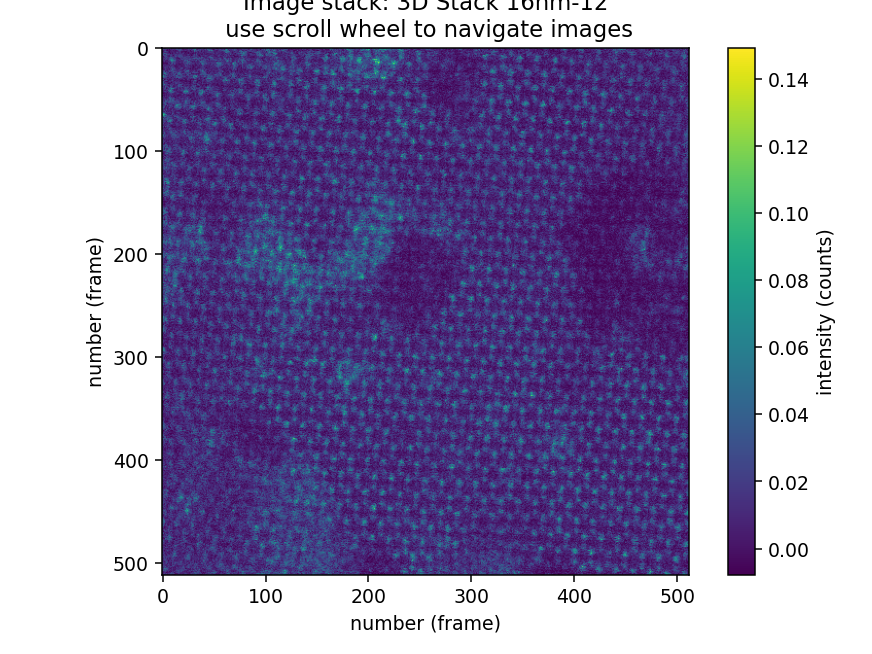

In [3]:
if main_dataset.data_type.name != 'IMAGE_STACK':
    print(f"Please load an image stack for this notebook, this is an {main_dataset.data_type}")
print(main_dataset)    
main_dataset.dim_0.dimension_type = 'spatial'
main_dataset.dim_1.dimension_type = 'spatial'
main_dataset.z.dimension_type = 'temporal'
view = main_dataset.plot()  # note this needs a view reference for interaction

In [4]:
main_dataset._axes
frame_dim = []
spatial_dim = []
for i, axis in main_dataset._axes.items():
    if axis.dimension_type.name == 'SPATIAL':
        spatial_dim.append(i)
    else:
        frame_dim.append(i)
        
if len(spatial_dim) != 2:
    print('need two spatial dimensions')
if len(frame_dim) != 1:
    print('need one frame dimensions')


## Complete Registration 

Takes a while, depending on your computer between 1 and 10 minutes.

In [10]:
## Do all of registration
notebook_tags ={'notebook': __notebook__, 'notebook_version': __notebook_version__}

non_rigid_registered, rigid_registered_dataset = px.image.complete_registration(main_dataset)
    
non_rigid_registered.plot()
non_rigid_registered

Rigid_Registration
Stack contains  20  images, each with 512  pixels in x-direction and  512  pixels in y-direction


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.32it/s]


Non-Rigid_Registration


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [05:46<00:00, 17.34s/it]


:-)
You have successfully completed Diffeomorphic Demons Registration


NameError: Datasets with UNKNOWN data_types cannot be plotted

In [18]:
non_rigid_registered
non_rigid_registered.dim_1.dimension_type = 'spatial'
non_rigid_registered.dim_2.dimension_type = 'spatial'
non_rigid_registered.dim_0.dimension_type = 'temporal'
non_rigid_registered.data_type = 'image_stack'
print(non_rigid_registered)
view = non_rigid_registered.sum(axis=0).plot()
non_rigid_registered

sidpy.Dataset of type IMAGE_STACK with:
 dask.array<array, shape=(20, 506, 509), dtype=float64, chunksize=(20, 506, 509), chunktype=numpy.ndarray>
 data contains: generic (generic)
 and Dimensions: 
frame:  number (frame) of size (20,)
x:  number (x) of size (506,)
y:  number (y) of size (509,)
 with metadata: ['analysis', 'input_crop', 'input_shape']


NotImplementedError: Datasets with data_type DataType.IMAGE_STACK cannot be plotted, yet.

### Check Drift

In [54]:
scale_x = (rigid_registered_dataset.x[1]-rigid_registered_dataset.x[0])*1.
drift = rigid_registered_dataset.metadata['drift']
x = np.linspace(0,drift.shape[0]-1,drift.shape[0])

polynom_degree = 2 # 1 is linear fit, 2 is parabolic fit, ...
line_fit_x = np.polyfit(x, drift[:,0], polynom_degree)
poly_x = np.poly1d(line_fit_x)
line_fit_y = np.polyfit(x, drift[:,1], polynom_degree)
poly_y = np.poly1d(line_fit_y)


plt.figure()
# plot drift and fit of drift
plt.axhline(color = 'gray')
plt.plot(x, drift[:,0], label = 'drift x')
plt.plot(x, drift[:,1], label = 'drift y')
plt.plot(x, poly_x(x),  label = 'fit_drift_x')
plt.plot(x, poly_y(x),  label = 'fit_drift_y')
plt.legend();

# set second axis in pico meter
ax_pixels = plt.gca()
ax_pixels.step(1, 1)
ax_pm = ax_pixels.twinx()
x_1, x_2 = ax_pixels.get_ylim()
ax_pm.set_ylim(x_1*scale_x, x_2*scale_x)

# add labels
ax_pixels.set_ylabel('drift [pixels]')
ax_pm.set_ylabel('drift [nm]')
ax_pixels.set_xlabel('image number');
plt.tight_layout()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Appendix

### Demon Registration

Here we use the **Diffeomorphic Demon Non-Rigid Registration** as provided by **simpleITK**.  

Please Cite: 
* [simpleITK](http://www.simpleitk.org/SimpleITK/project/parti.html)
    
    and
    
* [T. Vercauteren, X. Pennec, A. Perchant and N. Ayache *Diffeomorphic Demons Using ITK\'s Finite Difference Solver Hierarchy* The Insight Journal, 2007](http://hdl.handle.net/1926/510)

This Non-Rigid Registration consists of the following steps:

- determine ``reference`` image
    - For this we use the average of the rigid registered stack
    - this averaged stack is then smeared with a Gaussian of sigma 2 pixel to reduce noise
    - under the assumption that high frequency scan distortions cancel out over several images, we, therefore, obtained the center of mass of the atoms. 

- perform the ``demon registration`` filter to determine a distortion matrix
    - each single image of a stack is first smeared with a Gaussian of sigma of 2pixels
    - then the deformation matrix is determined for these images
    - the deformation matrix is a matrix where each pixel has a vector ( x, and y value) for the relative shift of this pixel.
    
- This deformation matrix is used to ``transform`` the image
	- The transformation is performed on the original image.
	- Important, here, is to set the interpolator method, (the image needs to be interpolated because the new pixels are not on an integer grid.)
    
    
Let's see what the different interpolators do.

|Method	| RMS contrast |	Standard |	Mean |
|-------|:--------------|:-------------|:-------|
|original   |0.1965806	|0.07764114	|0.3949583
|Linear	    |0.20159315	|0.079470366	|0.39421165
|BSpline	|0.20162606	|0.0794831 	|0.39421043
|Gaussian	|0.14310582	|0.056414302 	|0.39421389
|Hamming	|0.20163293	|0.07948672 	|0.39421496

The Gaussian interpolator is the only one seems to smear the signal.

We will use the ``Bspline`` method a fast and simple method that does not introduce spurious features and does not smear the signal.


#### Full Code of Demon registration 

In [ ]:
import simpleITK as sitk

def DemonReg(cube, verbose = False):
    """
    Diffeomorphic Demon Non-Rigid Registration 
    Usage:
    
    DemReg = DemonReg(cube, verbose = False)

    Input:
        cube: stack of image after rigid registration and cropping
    Output:
        DemReg: stack of images with non-rigid registration

    Dempends on:
        simpleITK and numpy
    
    Please Cite: http://www.simpleitk.org/SimpleITK/project/parti.html
    and T. Vercauteren, X. Pennec, A. Perchant and N. Ayache
    Diffeomorphic Demons Using ITK\'s Finite Difference Solver Hierarchy
    The Insight Journal, http://hdl.handle.net/1926/510 2007
    """
    
    DemReg =  np.zeros_like(cube)
    nimages = cube.shape[0]
    print(nimages)
    # create fixed image by summing over rigid registration

    fixed_np = np.average(current_dataset, axis=0)

    fixed = sitk.GetImageFromArray(fixed_np)
    fixed = sitk.DiscreteGaussian(fixed, 2.0)

    #demons = sitk.SymmetricForcesDemonsRegistrationFilter()
    demons = sitk.DiffeomorphicDemonsRegistrationFilter()

    demons.SetNumberOfIterations(200)
    demons.SetStandardDeviations(1.0)

    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed);
    resampler.SetInterpolator(sitk.sitkBspline)
    resampler.SetDefaultPixelValue(0)

    done = 0
        
    for i in range(nimages):
        if done < int((i+1)/nimages*50):
            done = int((i+1)/nimages*50)
            sys.stdout.write('\r')
            # progress output :
            sys.stdout.write("[%-50s] %d%%" % ('*'*done, 2*done))
            sys.stdout.flush()
        
        moving = sitk.GetImageFromArray(cube[i])
        movingf = sitk.DiscreteGaussian(moving, 2.0)
        displacementField = demons.Execute(fixed,movingf)
        outTx = sitk.DisplacementFieldTransform( displacementField )
        resampler.SetTransform(outTx)
        out = resampler.Execute(moving)
        DemReg[i,:,:] = sitk.GetArrayFromImage(out)
        #print('image ', i)
        
    
    print(':-)')
    print('You have succesfully completed Diffeomorphic Demons Registration')
    
    return DemReg
